In [147]:
#@hidden_cell

from IPython.core.display import HTML
from IPython.display import display
tag = HTML('''
<style>
    /*TU color table */
    :root {
      --tu-black:        rgb(0,0,0);
      --tu-white:        rgb(255,255,255);
      --tu-cyan:         rgb(0,166,214);
      --tu-green:        rgb(165,202,26);
      --tu-yellow:       rgb(225,196,0);
      --tu-orange:       rgb(230,70,22);
      --tu-red:          rgb(225,26,26);
      --tu-purple:       rgb(109,23,127);
      --tu-slategreen:   rgb(107,134,137);
      --tu-turqoise:     rgb(0,136,145);
      --tu-darkblue:     rgb(29,28,115);
      --tu-skyblue:      rgb(110,187,213);
    }
    h2, h3, h4 {
        background-color: var(--tu-white);
        color: var(--tu-black);
    }
    h1 {
        background-color: var(--tu-black);
        color: var(--tu-white);
    }
    em {
        color: var(--tu-cyan);
    }
     
    div.output_stdout {
        background-color: var(--tu-green);
        color: var(--tu-black);
    }
    div.output_stdout:before {
        content: "stdout output;";
    }
    div.output_stderr {
        background-color: var(--tu-yellow);
        color: var(--tu-black);
    }
    div.output_stderr:before {
        content: "stderr output;";
    }
</style>
<script>
    code_show=true; 
    IPython.OutputArea.prototype._should_scroll = function(lines) {
        return false;
    }
    function code_toggle() {
        if (code_show){
            $('div.cell.code_cell.rendered.selected div.input').hide();
        } else {
            $('div.cell.code_cell.rendered.selected div.input').show();
        }
        code_show = !code_show
    }     
    $( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()"><h4>Notebook settings</h4></a>
''')
display(tag)

# Stock Predictor Work

The stock prediction app aims to make real time prediction of the stocks for oil companies, based on the oil and euro prices, plus a consistent amount of past data. 

In the future, in order to make the prediction more robust, there will be an analysis of the sentiment of the market on the status of oil, euro to usd  and suited companies. 

The data will be validated with recurrent tests to evaluate the precision of the prediction on a particular company. 

## Table of Contents:
* [0 - Import Packages](#packages)
* [1 - Retreive and Handle Data](#retreival)
* [2 - Study of Correlation](#correlation)

## 0 - Import Packages <a class="anchor" id="packages"></a>

Importing necessary packages

In [219]:
# machine learning packages
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
       pass
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model

# data handling
import yfinance as yf
import numpy as np
import scipy
import scipy.linalg
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# plotting packages
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# other packages
import datetime as dt
import os

## 1 - Retreive and Handle Data <a class="anchor" id="retreival"></a>

In [220]:
# INPUT: [Company Name, Days in the Past, Intervals]

company_name = "RDS-B"
interval = "1d"
days = 5000

# get daytime and previous 7 days

currentDT = dt.datetime.now()
pastDT = currentDT - dt.timedelta(days=days)
currentDT = str(currentDT)[:10]
pastDT = str(pastDT)[:10]

company = yf.download(company_name, start=pastDT, end=currentDT, interval=interval)
euro = yf.download("EURUSD=X", start=pastDT, end=currentDT, interval=interval)
oil = yf.download("CL=F", start=pastDT, end=currentDT, interval=interval)

# build dataframe

data = pd.DataFrame()

data = data.assign(company_open = company['Open'])
data = data.assign(company_close = company['Close'])
data = data.assign(euro_open = euro['Open'])
data = data.assign(euro_close = euro['Close'])
data = data.assign(oil_open = oil['Open'])
data = data.assign(oil_close = oil['Close'])
data = data.dropna()

# add return value for each interval

data = data.assign(company_return = (company["Close"] - company["Open"]))
data = data.assign(euro_return = (euro["Close"] - euro["Open"]))
data = data.assign(oil_return = (oil["Close"] - oil["Open"]))

data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,company_open,company_close,euro_open,euro_close,oil_open,oil_close,company_return,euro_return,oil_return
Date,,,,,,,,,
2006-09-21,67.559998,67.809998,1.268698,1.278102,60.810001,61.590000,0.250000,0.009405,0.779999
2006-09-22,67.769997,66.949997,1.278200,1.280000,61.709999,60.549999,-0.820000,0.001800,-1.160000
2006-09-25,67.010002,67.279999,1.279296,1.274502,60.250000,61.450001,0.269997,-0.004794,1.200001
2006-09-26,66.400002,67.199997,1.274892,1.268698,61.439999,61.009998,0.799995,-0.006195,-0.430000
2006-09-27,67.570000,68.309998,1.268794,1.270600,61.139999,62.959999,0.739998,0.001806,1.820000
...,...,...,...,...,...,...,...,...,...
2020-05-22,30.639999,30.340000,1.095242,1.095290,31.840000,33.560001,-0.299999,0.000048,1.720001
2020-05-26,31.170000,30.940001,1.090108,1.090300,34.180000,34.029999,-0.230000,0.000191,-0.150002
2020-05-27,31.620001,31.070000,1.098056,1.098177,34.200001,31.730000,-0.550001,0.000121,-2.470001


## 3 - Study of Correlation <a class="anchor" id="correlation"></a>

<IPython.core.display.Javascript object>


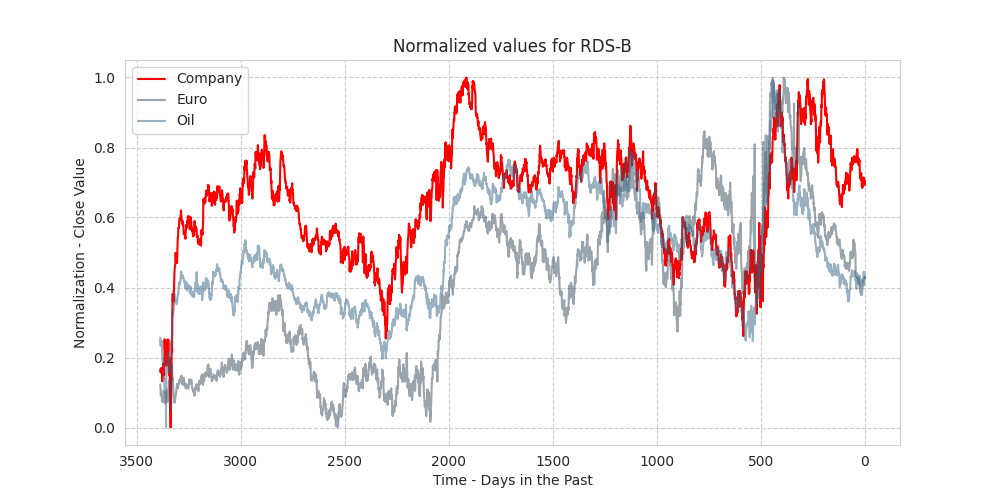

In [221]:
# plot closing value for three indicators

expl_1 = data[['company_close', 'euro_close', 'oil_close']]

expl_1 = MinMaxScaler().fit_transform(expl_1)

with sns.color_palette("Blues_d"):
    
    plt.figure(figsize=(10, 5))
    sns.set_style('whitegrid', {'grid.linestyle': '--'})
    ax = sns.lineplot(data=expl_1[:,0], alpha=1, color='r')
    ax = sns.lineplot(data=expl_1[:,1], alpha=0.5)
    ax = sns.lineplot(data=expl_1[:,2], alpha=0.5)
    ax.invert_xaxis()
    ax.set_title(f'Normalized values for {company_name}')
    ax.legend(loc='upper left', labels=['Company', 'Euro', 'Oil'])
    ax.set(xlabel='Time - Days in the Past', ylabel='Normalization - Close Value')

<IPython.core.display.Javascript object>


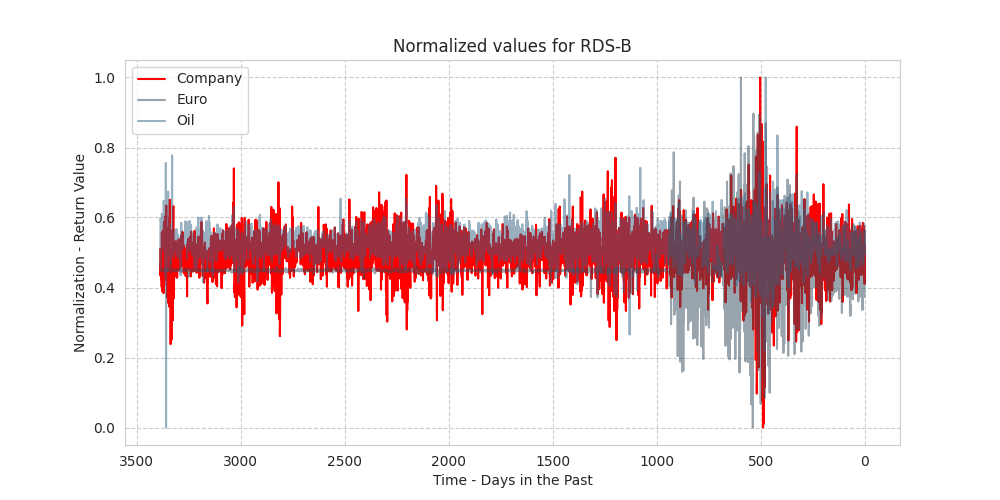

In [222]:
# plot return value for each indicator

expl_2 = data[['company_return', 'euro_return', 'oil_return']]

expl_2 = MinMaxScaler().fit_transform(expl_2)

with sns.color_palette("Blues_d"):
    
    plt.figure(figsize=(10, 5))
    sns.set_style('whitegrid', {'grid.linestyle': '--'})
    ax = sns.lineplot(data=expl_2[:,0], alpha=1, color='r')
    ax = sns.lineplot(data=expl_2[:,1], alpha=0.5)
    ax = sns.lineplot(data=expl_2[:,2], alpha=0.5)
    ax.invert_xaxis()
    ax.set_title(f'Normalized values for {company_name}')
    ax.legend(loc='upper left', labels=['Company', 'Euro', 'Oil'])
    ax.set(xlabel='Time - Days in the Past', ylabel='Normalization - Return Value')

<IPython.core.display.Javascript object>


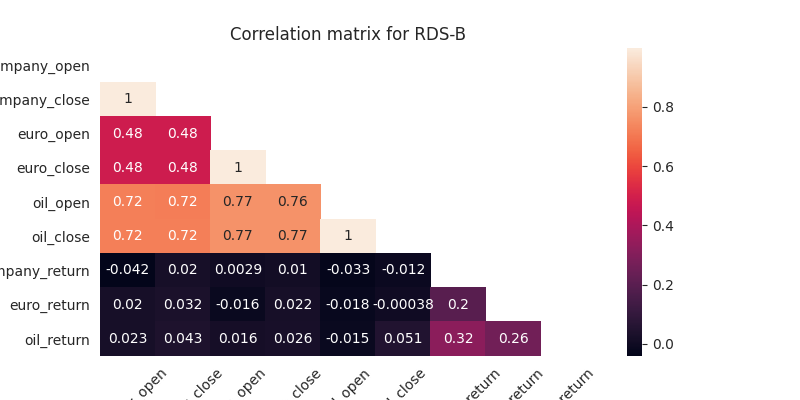

In [223]:
# Build correlation matrix for all gathered values

corr = data[['company_open', 'company_close', 'euro_open', 'euro_close', 'oil_open', 'oil_close', 'company_return', 'euro_return', 'oil_return']].corr()

plt.figure(figsize=(8, 4))
mask = np.triu(np.ones_like(corr, dtype=np.bool))
corr_plot = sns.heatmap(corr, mask=mask, annot=True)
corr_plot.set_title(f"Correlation matrix for {company_name}")



for item in corr_plot.get_xticklabels():
    item.set_rotation(45)

plt.show()

## 3 - RNN Based Prediction Forecast <a class="anchor" id="rnn"></a>

Based on the correlation indices obtained in the correlation matrix, the features to be considered for now present 3 stock values: oil, company and euro to usd change.

In [224]:
features_considered = ['company_close', 'euro_close', 'oil_close']

features = data[features_considered]
features

,company_close,euro_close,oil_close
Date,,,
2006-09-21,67.809998,1.278102,61.590000
2006-09-22,66.949997,1.280000,60.549999
2006-09-25,67.279999,1.274502,61.450001
2006-09-26,67.199997,1.268698,61.009998
2006-09-27,68.309998,1.270600,62.959999
...,...,...,...
2020-05-22,30.340000,1.095290,33.560001
2020-05-26,30.940001,1.090300,34.029999
2020-05-27,31.070000,1.098177,31.730000


Here the values in the dataset must be splitted for training and testing of the tool

In [235]:
data_number = features.shape[0]
train_split = int(0.9 * data_number)

dataset = features.values
data_mean = dataset[:train_split].mean(axis=0)
data_std = dataset[:train_split].std(axis=0)

dataset = (dataset-data_mean)/data_std

print(f"mean normalized dataset of features = \n\n {dataset} \n")

print(f"shape of dataset = {dataset.shape}")

mean normalized dataset of features = 

 [[ 0.29229036 -0.04517283 -0.56407211]
 [ 0.20960675 -0.03035021 -0.60956904]
 [ 0.24133434 -0.07329195 -0.57019666]
 ...
 [-3.24002737 -1.45054411 -1.87035768]
 [-3.25541034 -1.4231401  -1.78811326]
 [-3.3005978  -1.37451755 -1.71330592]] 

shape of dataset = (3387, 3)


### 3.1 - Batch Generation

The code below gets the data selected and builds partitions that will be used to train. More in specific:

* **Data** is the known information that is expected to be given for the prediction
* **Label** is the true value that one wants to predict, in our case the closing value of a company

In [226]:
# batch generation algorithm

def make_partitions(dataset, label, start, end, past_size, future_size, step, single_step=False):
    
    data = []
    labels = []
    
    start += past_size
    
    if end is None:
        # then the dataset is finished, adapt to furthest future we have
        end = len(dataset) - future_size
        
    for datum in range(start, end):
        # make an array of n training batches of m past data collection of x variables (3D array)
        idx = range(datum - past_size, datum, step)
        data.append(dataset[idx])
        
        if single_step: # then we create batches to predict only in the next observation
            labels.append(label[datum + future_size])
        
        else:
            labels.append(label[datum:datum+future_size])
            
    return np.array(data), np.array(labels)

In [280]:
# define partitions

# INPUT: [to predict, past values used, prediction values, steps]

labels = dataset[:, 0] #  getting company close
n_past = 50 #  time stamps that will affect the future values (the more the more computing)
n_prediction = 5 #  the time stamp in the future of which we want to find the prediction
STEP = 1

train_partitions, train_labels = make_partitions(dataset, labels, 0, train_split, n_past, n_prediction, STEP)

valid_partitions, valid_labels = make_partitions(dataset, labels, train_split, None, n_past, n_prediction, STEP)

print(f"By considering the contributing variables and the data instered, we obtain: ")
print(f"\nTrain data of shape: {train_partitions.shape} and {train_labels.shape}")
print(f"\nValidation data of shape: {valid_partitions.shape} and {valid_labels.shape}\n")
print ('Single window of past history : {}'.format(train_partitions[0].shape))
print ('Single window of predicted output : {}'.format(train_labels[0].shape))

By considering the contributing variables and the data instered, we obtain: 

Train data of shape: (2998, 50, 3) and (2998, 5)

Validation data of shape: (284, 50, 3) and (284, 5)

Single window of past history : (50, 3)
Single window of predicted output : (5,)


Let's now use tf.data to shuffle, batch, and cache the dataset.

Info buffer size: The buffer_size in Dataset.shuffle() can affect the randomness of your dataset, and hence the order in which elements are produced. The buffer_size in Dataset.prefetch() only affects the time it takes to produce the next element.

Info batch size: the batch size make batches out of the data shape specified. 

In [281]:
BATCH_SIZE = 100 #  single example batch size
BUFFER_SIZE = 1000 #  level of randomness

train = tf.data.Dataset.from_tensor_slices((train_partitions, train_labels))
train_data = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

validate = tf.data.Dataset.from_tensor_slices((valid_partitions, valid_labels))
validation_data = validate.batch(BATCH_SIZE).repeat()

print(train_data)
print(validation_data)

<DatasetV1Adapter shapes: ((?, 50, 3), (?, 5)), types: (tf.float64, tf.float64)>
<DatasetV1Adapter shapes: ((?, 50, 3), (?, 5)), types: (tf.float64, tf.float64)>


### 3.2 - Building Prediction Model

Once the data is ready to be fed, the model needs to be build and fed with these ones. The current model is built as following around a specialized RNN layer called Long Short Term Memory (LSTM). The model is built as following:

- **models**: Code for model cloning, plus model-related API entries. It can be of class `Model` (groups layers into an object with training and inference features) or `Sequential` (Linear stack of layers)

- **layers**: Type of model layers: its full of choices for for now we will use LSTM and Dense, but it can be changed). 

- **optimizer**: it defines the error required to be minimized, in this case MAE

In [282]:
# LSTM requires the input shape of the data it is being given.

lstm_model = tf.keras.models.Sequential()

lstm_model.add(tf.keras.layers.LSTM(32,
                                    return_sequences=True, 
                                    input_shape=train_partitions.shape[-2:])) # 32 units
               
lstm_model.add(tf.keras.layers.LSTM(16,
                                    activation='relu')) # 32 unitstrain_batches.shape[-2:])) # 32 units
               
lstm_model.add(tf.keras.layers.Dense(n_prediction)) # 1 unit

lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

### 3.3 - Train the Model

The next step is to feed training data to the model defined to obtain a predictive algorithm. The information to define is the following (see fit https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

- `EPOCHS`: Iterations on the dataset
- `EVAUATION INTERVAL`: Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size.
- `validation_steps`:  Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.

In [288]:
EVALUATION_INTERVAL = 10
EPOCHS = 40

trained_alg = lstm_model.fit(train_data, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=validation_data,
                                            validation_steps=50)

Epoch 1/40
10/10 [==============================] - 3s 252ms/step - loss: 0.1382 - val_loss: 0.1985
Epoch 2/40
10/10 [==============================] - 1s 75ms/step - loss: 0.1307 - val_loss: 0.1952
Epoch 3/40
10/10 [==============================] - 1s 77ms/step - loss: 0.1186 - val_loss: 0.1796
Epoch 4/40
10/10 [==============================] - 1s 79ms/step - loss: 0.1343 - val_loss: 0.1998
Epoch 5/40
10/10 [==============================] - 1s 79ms/step - loss: 0.1240 - val_loss: 0.1830
Epoch 6/40
10/10 [==============================] - 1s 79ms/step - loss: 0.1208 - val_loss: 0.1914
Epoch 7/40
10/10 [==============================] - 1s 79ms/step - loss: 0.1361 - val_loss: 0.1875
Epoch 8/40
10/10 [==============================] - 1s 75ms/step - loss: 0.1266 - val_loss: 0.2306
Epoch 9/40
10/10 [==============================] - 1s 104ms/step - loss: 0.1176 - val_loss: 0.1919
Epoch 10/40
10/10 [==============================] - 1s 139ms/step - loss: 0.1382 - val_loss: 0.1976
Epoch 

### 3.4 - Validate the Model

Time to validate. First step is to check for every epoch what is the loss and the validation loss. This can help us in understanding if the current training model is not diverging in errors; if so, then we have to change parameters. 

<IPython.core.display.Javascript object>


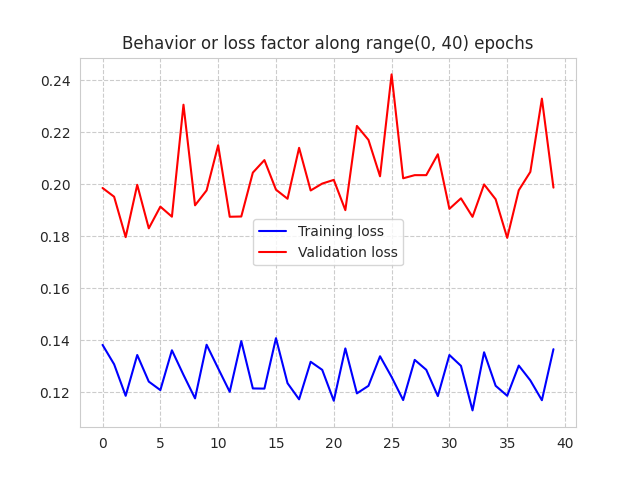

In [289]:
# define a function to plot the loss factors

def plot_train_history(history):
    
    # from the trained algorithm is possible to retieve the loss data during training and validation
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # the x axis corresponds to the epochs that we performed
    epochs = range(len(loss))
    
    # plot the values
    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f"Behavior or loss factor along {epochs} epochs")
    plt.legend()

    plt.show()
    
plot_train_history(trained_alg)

<IPython.core.display.Javascript object>


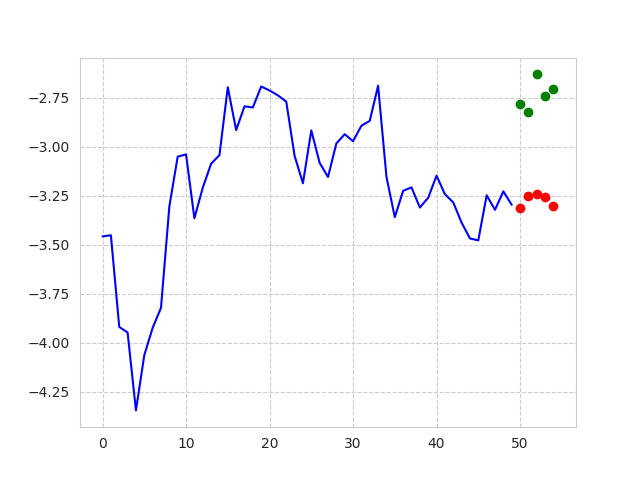

In [291]:
# now collect validation data and make predictions, see how they go

test = dataset[-55:-5, :]
test = test[np.newaxis, ...]

true = dataset[-5:, 0]

prediction = lstm_model.predict(test)

x_axis_1 = np.arange(55)

"""print(test)
print(true)
print(prediction[0])
print(x_axis_1[-5:])"""

plt.figure()
plt.plot(x_axis_1[:50], test[0, :, 0], 'b')
plt.plot(x_axis_1[-5:], true, 'ro')
plt.plot(x_axis_1[-5:], prediction[0], 'go')
plt.show()